# Robustness Checks (0.5/0.3/0.2 split)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import tensorflow as tf
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Ensure plot qualities 
plt.rcParams['figure.figsize'] = (12,6)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  # Adjust DPI for high-resolution figures

In [3]:
# Define global environment variables

# Train-val-test split 
TRAIN_RATIO = 0.5
VAL_RATIO = 0.3
TEST_RATIO = 0.2

# Model hyperparameters 
WINDOW_SIZE = 60
NUM_NEURONS = 256
DROPOUT_RATE = 0.2144820307182468
PATIENCE = 5
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.002424273311073177

## Data analysis

In [4]:
data_path = "/Users/alexzheng/Developer/GitHub/EC331-project/EMH/Data/Bitcoin_data_2024_w_TI_n_Macro.csv"
data = pd.read_csv(data_path, index_col=0, parse_dates=True)

# Only select columns for weak form EMH
data = data.drop(columns=['fear_n_greed_index', 'SP500', 'CPI', 'Gold', 'Nasdaq100', 'VIX', 'Oil'])

data

,Open,High,Low,Close,VolumeBTC,Returns%,SMA_20,Volatility_20,RSI,MACD_Hist,ROC,CCI,WilliamsR,ADX
date,,,,,,,,,,,,,,
2024-01-01 00:34:00,42357.0,42357.0,42351.0,42351.0,0.019690,-0.047213,42439.60,45.249751,39.611671,-21.969636,-0.284894,-132.476899,-100.000000,44.942988
2024-01-01 00:35:00,42359.0,42359.0,42351.0,42359.0,0.031363,0.018888,42433.20,47.106900,42.075166,-20.371629,-0.275450,-107.157984,-93.600000,42.503637
2024-01-01 00:36:00,42368.0,42377.0,42356.0,42377.0,0.034081,0.042485,42425.65,43.250751,47.285831,-17.279376,-0.183724,-72.268194,-79.200000,39.498642
2024-01-01 00:37:00,42395.0,42411.0,42392.0,42403.0,0.005832,0.061335,42421.20,40.698403,53.756702,-12.862734,-0.077764,-8.262512,-58.400000,37.792666
2024-01-01 00:38:00,42403.0,42411.0,42400.0,42402.0,0.998563,-0.002358,42417.80,39.295801,53.484759,-9.541278,-0.016506,6.784413,-59.200000,36.208545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:55:00,93476.0,93476.0,93471.0,93471.0,0.179799,-0.023534,93353.00,82.097503,61.853949,24.510813,0.166102,80.515852,-10.045662,23.141107
2024-12-31 23:56:00,93469.0,93469.0,93469.0,93469.0,0.021400,-0.002140,93362.30,84.150520,61.432197,21.537986,0.156446,66.290491,-12.565445,22.308489
2024-12-31 23:57:00,93462.0,93462.0,93413.0,93427.0,0.034750,-0.044945,93368.75,83.918338,53.224757,15.865447,0.115732,29.607917,-35.869565,21.254018


In [5]:
# The number of missing values
data.isna().sum()

Open             0
High             0
Low              0
Close            0
VolumeBTC        0
Returns%         0
SMA_20           0
Volatility_20    0
RSI              0
MACD_Hist        0
ROC              0
CCI              0
WilliamsR        0
ADX              0
dtype: int64

## Data processing

In [6]:
# Train-val-test split
train_ratio = TRAIN_RATIO
val_ratio = VAL_RATIO
test_ratio = TEST_RATIO

# Compute split indices
train_index = int(len(data) * train_ratio)
val_index = train_index + int(len(data) * val_ratio)

# Perform the splits
train_data = data.iloc[:train_index]
val_data = data.iloc[train_index:val_index]
test_data = data.iloc[val_index:]

# Print the shapes to confirm
print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)
print("Test shape:", test_data.shape)

Train shape: (254707, 14)
Validation shape: (152824, 14)
Test shape: (101883, 14)


In [7]:
# Ensure WINDOW_SIZE does not exceed dataset length
assert WINDOW_SIZE < len(train_data), "WINDOW_SIZE is too large for the dataset size!"

In [8]:
print("Train start:", train_data.index[0], "end:", train_data.index[-1])
print("Val start:", val_data.index[0], "end:", val_data.index[-1])
print("Test start:", test_data.index[0], "end:", test_data.index[-1])

Train start: 2024-01-01 00:34:00 end: 2024-07-02 09:43:00
Val start: 2024-07-02 09:44:00 end: 2024-10-18 19:24:00
Test start: 2024-10-18 19:25:00 end: 2024-12-31 23:59:00


In [9]:
# Fit scaler ONLY on training data
scaler = MinMaxScaler()
scaler.fit(train_data) # Fit only on training data

MinMaxScaler()

In [10]:
# Transform train, validation, and test data using the fitted scaler
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [11]:
# Function to create sequences for time series forecasting
def create_sequences(data_array, window_size, target_col_idx):
    X, y = [], []
    for i in range(len(data_array) - window_size):
        X.append(data_array[i:(i + window_size), :])
        y.append(data_array[i + window_size, target_col_idx])
    return np.array(X), np.array(y)

In [12]:
# Define window size and target column
window_size = WINDOW_SIZE
target_col = 'Returns%'
target_col_idx = data.columns.get_loc(target_col)

# Create sequences for training, validation and test sets
X_train, y_train = create_sequences(train_scaled, window_size, target_col_idx)
X_val, y_val = create_sequences(val_scaled, window_size, target_col_idx)
X_test, y_test = create_sequences(test_scaled, window_size, target_col_idx)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(254647, 60, 14) (254647,)
(152764, 60, 14) (152764,)
(101823, 60, 14) (101823,)


## Model training (GRU)

In [13]:
# # Define GRU model
# gru_model = Sequential([
#     GRU(NUM_NEURONS, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(DROPOUT_RATE),
#     Dense(1) # Predicting the Returns%
# ])
# gru_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')
# gru_model.summary()

In [14]:
# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)

# # Train the model
# history = gru_model.fit(
#     X_train, y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stopping],
#     verbose=1
# )

In [15]:
# # Training and validation loss
# history.history.keys()

In [16]:
# # Plot training and validation loss
# # plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# # plt.title('Training vs Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

### Save the fitted scaler and the model

In [17]:
# Relative path 
relative_path = "/Users/alexzheng/Developer/GitHub/EC331-project/EMH/models/"

In [18]:
# import joblib

# # Save model and scaler in a 'models' directory
# gru_model.save(f"{relative_path}gru_model_1.keras")  # Saves architecture + weights
# joblib.dump(scaler, f"{relative_path}gru_scaler_1.pkl")  # Saves fitted scaler

## Evaluation

In [19]:
from keras.models import load_model
import joblib

# Load trained model
gru_model = load_model("/Users/alexzheng/Developer/GitHub/EC331-project/EMH/models/gru_model_1_best.keras")

# Load trained scaler
scaler = joblib.load("/Users/alexzheng/Developer/GitHub/EC331-project/EMH/models/scaler_best_1.pkl")

In [20]:
# Crate an inverse function
def inverse_transform_predictions(predicted_scaled, y_actual_scaled, scaler, train_data, target_col_idx):
    """
    Inverse transforms the scaled predictions and actual values back to the original scale.

    Parameters:
    - predicted_scaled: Model predictions in scaled form (shape: (n_samples, 1)).
    - y_actual_scaled: Actual target values in scaled form (shape: (n_samples,)).
    - scaler: The MinMaxScaler fitted on the training data.
    - train_data: The original training dataset (used to get the number of features for inverse transform).
    - target_col_idx: The index of the target column in the dataset.

    Returns:
    - predicted_inverse: Predictions in the original scale.
    - y_actual_inverse: Actual values in the original scale.
    """

    # Create full arrays with the same shape as train_data for inverse transformation
    predicted_full = np.zeros((predicted_scaled.shape[0], train_data.shape[1]))
    y_actual_full = np.zeros((y_actual_scaled.shape[0], train_data.shape[1]))

    # Fill only the target column (Returns%)
    predicted_full[:, target_col_idx] = predicted_scaled[:, 0]  # Ensure correct shape
    y_actual_full[:, target_col_idx] = y_actual_scaled  # y_actual is already 1D

    # Apply inverse transform
    predicted_inverse = scaler.inverse_transform(predicted_full)[:, target_col_idx]
    y_actual_inverse = scaler.inverse_transform(y_actual_full)[:, target_col_idx]

    return predicted_inverse, y_actual_inverse

### Validation set evaluation

In [21]:
# Evaluation function
def evaluate_forecast(actual, predicted, label=""):
    mae = mean_absolute_error(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f"{label} MAE: {mae:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")

In [22]:
# Get inverse transformed predictions and actual values
predicted_val_inverse, y_val_inverse = inverse_transform_predictions(
    predicted_scaled=gru_model.predict(X_val),
    y_actual_scaled=y_val,
    scaler=scaler,
    train_data=train_data,
    target_col_idx=target_col_idx
)

4774/4774 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step


In [23]:
# Compute error metrics for the test set
print("Validation Forecast Performance:")
evaluate_forecast(y_val_inverse, predicted_val_inverse, label="Validation")

Validation Forecast Performance:
Validation MAE: 0.0529
Validation RMSE: 0.0795


### Test set evaluation

In [24]:
# Get inverse transformed predictions and actual values
predicted_test_inverse, y_test_inverse = inverse_transform_predictions(
    predicted_scaled=gru_model.predict(X_test),
    y_actual_scaled=y_test,
    scaler=scaler,
    train_data=train_data,
    target_col_idx=target_col_idx
)

3182/3182 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step


In [25]:
# Compute error metrics for the test set
print("\nTest Forecast Performance:")
evaluate_forecast(y_test_inverse, predicted_test_inverse, label="Test")


Test Forecast Performance:
Test MAE: 0.0541
Test RMSE: 0.0778


### Validation and testing Plots

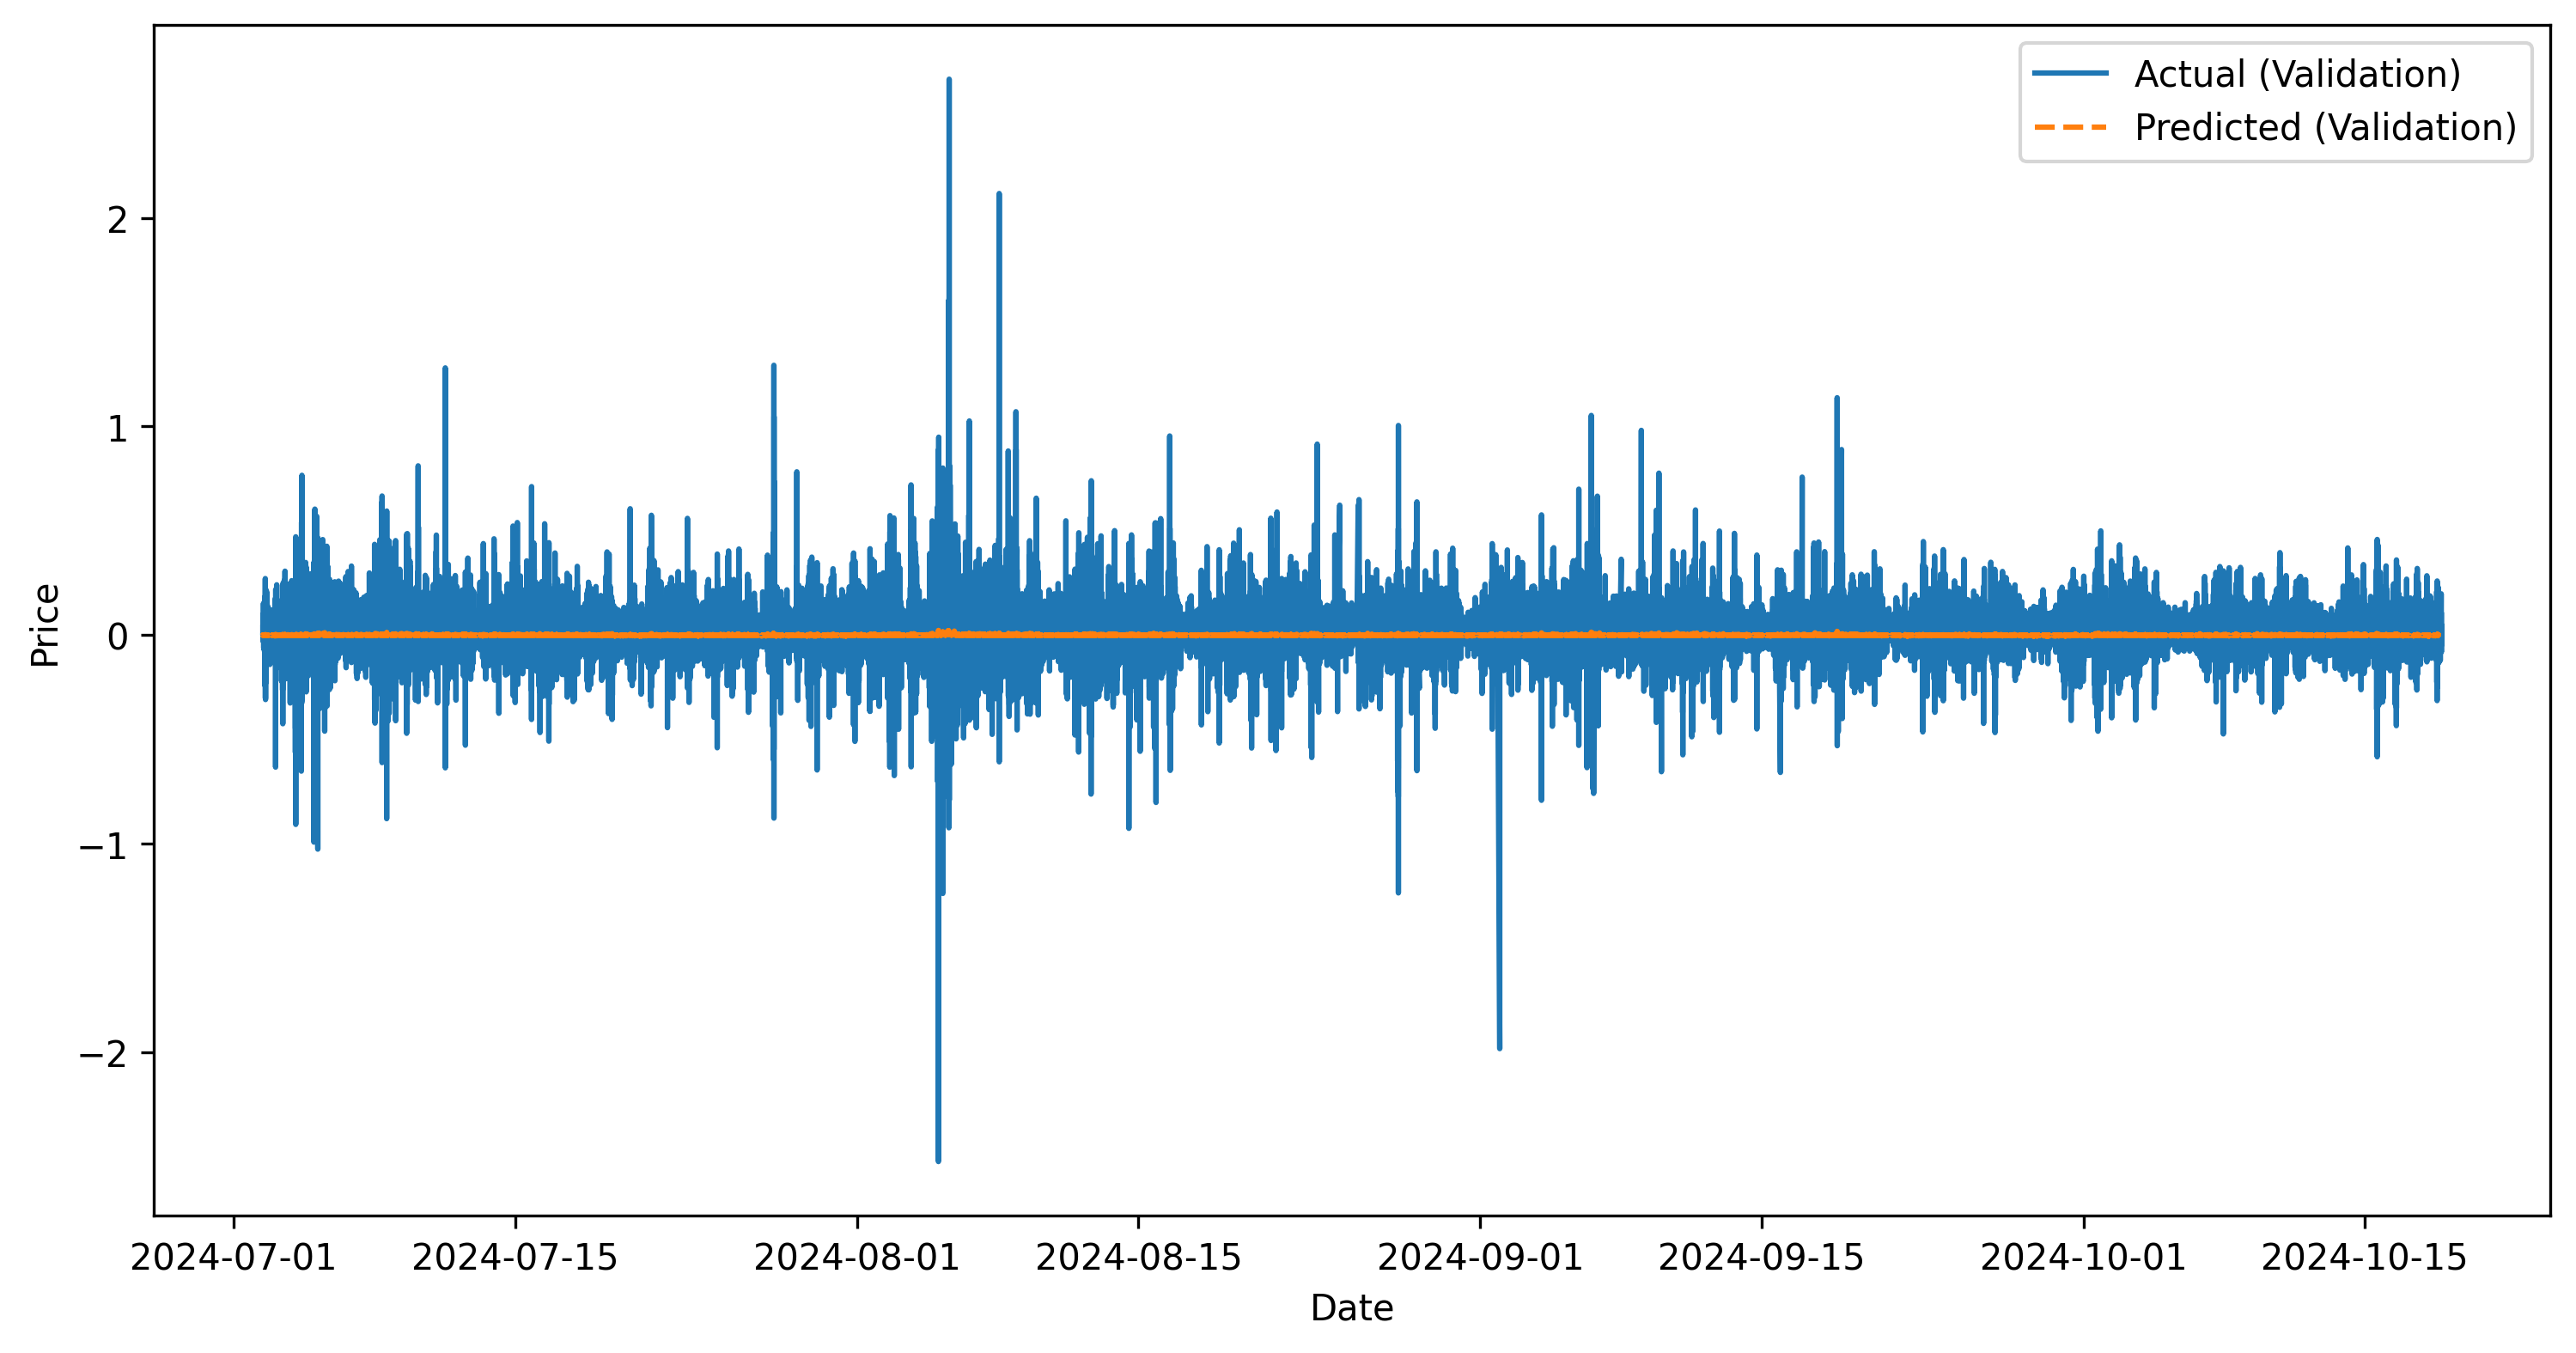

In [26]:
# Extract date index for plotting
date_index = val_data.index[window_size:]  # Align with sequence offset

# Plot actual vs predicted Returns% for validation set
plt.plot(date_index, y_val_inverse, label='Actual (Validation)')
plt.plot(date_index, predicted_val_inverse, label='Predicted (Validation)', linestyle='dashed')

# plt.title('GRU Forecast vs Actual Returns (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Price')

# Show only a few major ticks with full date format
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))  # Adjust the number of shown ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Full date format

# plt.xticks(rotation=45)
plt.legend()
plt.show()

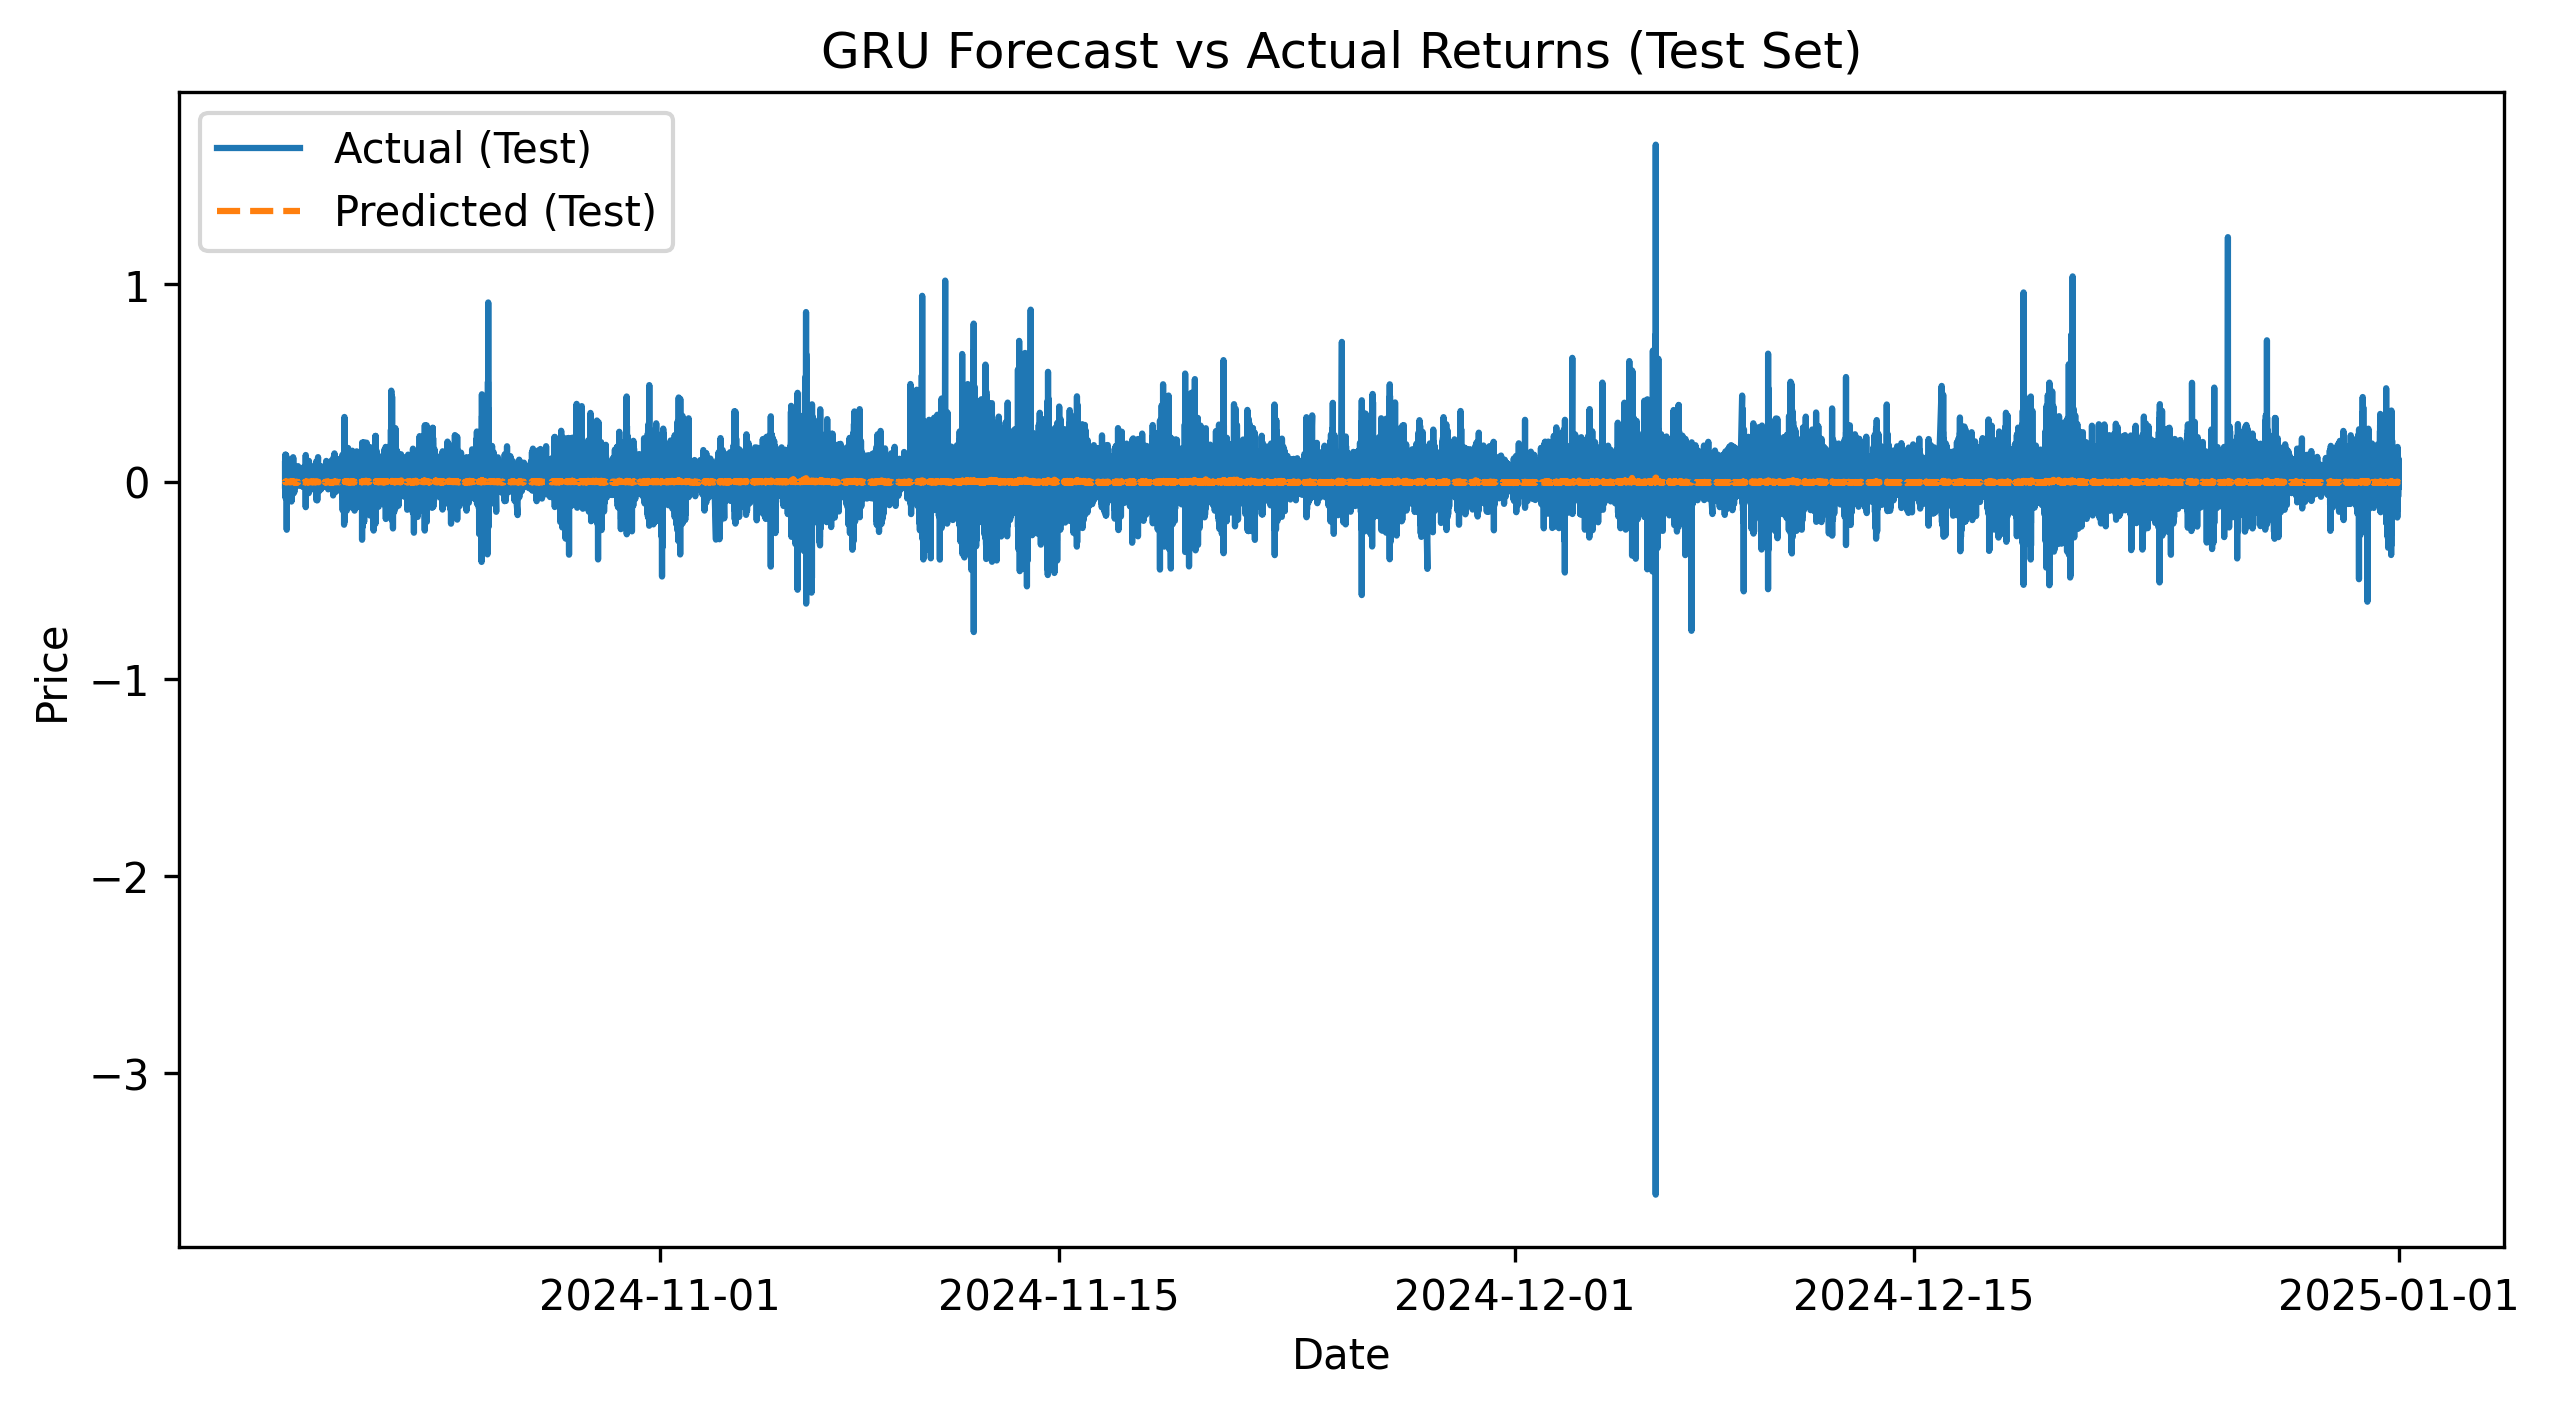

In [27]:
import matplotlib.dates as mdates

# Extract date index for plotting
plt.figure(figsize=(10, 5))
date_index = test_data.index[window_size:]  # Align with sequence offset

# Plot actual vs predicted Returns% for test set
plt.plot(date_index, y_test_inverse, label='Actual (Test)')
plt.plot(date_index, predicted_test_inverse, label='Predicted (Test)', linestyle='dashed')

plt.title('GRU Forecast vs Actual Returns (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')

# Show only a few major ticks with full date format
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))  # Adjust the number of shown ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Full date format

# plt.xticks(rotation=45)
plt.legend()
plt.show()

### Robustness Checks - against the Naïve Mean

In [28]:
train_returns = train_data['Returns%']
val_returns = val_data['Returns%']
test_returns = test_data['Returns%']

combined_train_val = data.iloc[:val_index]['Returns%']

In [29]:
# Calculate mean from the training set for validation forecast
mean_train = train_returns.mean()
benchmark_forecast_val = np.full(shape=len(val_returns), fill_value=mean_train)

print("Mean Benchmark Forecast Performance (Validation):")
evaluate_forecast(val_returns, benchmark_forecast_val, label="Benchmark - Validation")

# For the test set, use the combined training and validation data
mean_combined = combined_train_val.mean()
benchmark_forecast_test = np.full(shape=len(test_returns), fill_value=mean_combined)

print("\nMean Benchmark Forecast Performance (Test):")
evaluate_forecast(test_returns, benchmark_forecast_test, label="Benchmark - Test")

Mean Benchmark Forecast Performance (Validation):
Benchmark - Validation MAE: 0.0463
Benchmark - Validation RMSE: 0.0755

Mean Benchmark Forecast Performance (Test):
Benchmark - Test MAE: 0.0468
Benchmark - Test RMSE: 0.0731
